# New plotting classes have been added to flopy

these classes seamlessly support vertex model grid and unstructured model grid plotting using the new `PlotMapView` class. This classes will replace the previous `ModelMap` class; however backward compatibility is still supported through `ModelMap`.

`PlotMapView` has a similar interface as `ModelMap`. In most instances the two classes can be used interchangably. The biggest difference is that some of the input parameters have changed.

`sr` has been replaced with `modelgrid` since the SpatialRefernce class is being depreciated

Transforms using `xll`, `yll`, `xul`, `yul`, `rotation`, and `length_multiplier` have been removed from plot. The user should apply these transforms before passing their model grid to `PlotMapView`.

The remaining functionality remains the same!

In [1]:
import os
import sys

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import setup_pmv_demo

# run installed version of flopy or add local path
try:
    import flopy
    from flopy.plot import PlotMapView, PlotCrossSection, ModelMap, ModelCrossSection
    from flopy.utils import HeadFile, CellBudgetFile, geometry
    from flopy.discretization import UnstructuredGrid
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
    from flopy.plot import PlotMapView, PlotCrossSection, ModelMap, ModelCrossSection
    from flopy.utils import HeadFile, CellBudgetFile, geometry
    from flopy.discretization import UnstructuredGrid
      
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))  

flopy is installed in /Users/jdhughes/Documents/Development/flopy_git/flopy_us/flopy
3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.16.2
matplotlib version: 3.0.3
flopy version: 3.2.12


In [2]:
# create the model data to work with in this notebook using a helper module
setup_pmv_demo.run()


changing model workspace...
   data
FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/05/31 19:11:16

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2019/05/31 19:11:16
 Elapsed run time:  0.014 Seconds

  Normal termination of simulation
Output file located: freyberg.hds
Output file located: freyberg.cbc
FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mp6
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.0000

Now to load up example problems representing each grid type (DIS, DISV, and DISU)

### Starting with Freyberg for the DIS example

In [3]:
loadpth = os.path.join('..', 'data', 'freyberg')
modelpth = os.path.join('data')
dis_ml = flopy.modflow.Modflow.load('freyberg.nam', model_ws=loadpth, 
                                exe_name="mf2005", version="mf2005")
dis_ml.change_model_ws(new_pth=modelpth)
dis_ml.write_input()
success, buff = dis_ml.run_model()
if not success:
    print ('Something bad happened.')
files = ['freyberg.hds', 'freyberg.cbc']
for f in files:
    if os.path.isfile(os.path.join(modelpth, f)):
        msg = 'Output file located: {}'.format(f)
        print (msg)
    else:
        errmsg = 'Error. Output file cannot be found: {}'.format(f)
        print (errmsg)


changing model workspace...
   data
FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/05/31 19:11:17

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2019/05/31 19:11:17
 Elapsed run time:  0.019 Seconds

  Normal termination of simulation
Output file located: freyberg.hds
Output file located: freyberg.cbc


### The DISV example

In [4]:
# load up the vertex example problem
sim_name = "mfsim.nam"
sim_path = "../data/mf6/test003_gwftri_disv"
disv_sim = flopy.mf6.MFSimulation.load(sim_name=sim_name, version="mf6", exe_name="mf6",
                                       sim_ws=sim_path)
disv_ml = disv_sim.get_model('gwf_1')

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package chd...
    loading package oc...
  loading ims package gwf_1...


### And the DISU example

In [5]:
# This is a folder containing some unstructured grids
datapth = os.path.join('..', 'data', 'unstructured')

In [6]:
# Simple functions to load vertices and incidence lists
def load_verts(fname):
    return(np.genfromtxt(fname))

def load_iverts(fname):
    f = open(fname, 'r')
    iverts = []
    xc = []
    yc = []
    for line in f:
        ll = line.strip().split()
        iverts.append([int(i) - 1 for i in ll[4:]])
        xc.append(float(ll[1]))
        yc.append(float(ll[2]))
    return iverts, np.array(xc), np.array(yc)

In [7]:
# load vertices
fname = os.path.join(datapth, 'ugrid_verts.dat')
verts = load_verts(fname)[:, 1:]

# load the incidence list into iverts
fname = os.path.join(datapth, 'ugrid_iverts.dat')
iverts, xc, yc = load_iverts(fname)

In [8]:
ncpl = np.array(5 * [len(iverts)])
# using the SpatialReferenceUnstructured class since UnstructuredModelGrid has not been created yet
disu_mg = UnstructuredGrid(verts, iverts, xc, yc, ncpl=ncpl)
disu_sr = flopy.utils.reference.SpatialReferenceUnstructured(xc, yc, verts, iverts, ncpl)

## Plotting the model grid with each of these examples

### DIS (structured grid)

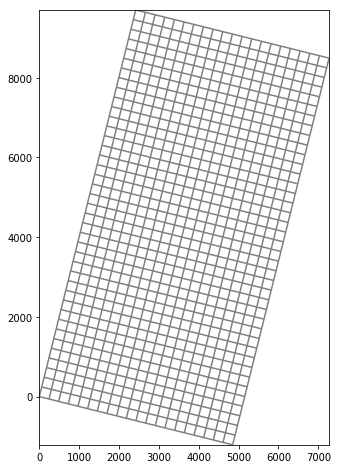

In [9]:
# setup our modelgrid rotation and offsets
dis_ml.modelgrid.set_coord_info(xoff=0., yoff=0, angrot=-14)

# First step is to set up the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

# Next we create an instance of the ModelMap class
mapview = flopy.plot.PlotMapView(model=dis_ml)

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
linecollection = mapview.plot_grid()

### Backward compatibility with `ModelMap` using a Structured discretization

/Users/jdhughes/Documents/Development/flopy_git/flopy_us/flopy/plot/map.py:1356: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


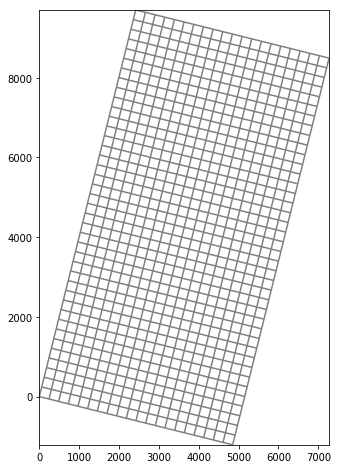

In [10]:
# First step is to set up the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

# Next we create an instance of the ModelMap class
modelmap = flopy.plot.ModelMap(model=dis_ml, xll=0, yll=0, rotation=-14)

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
linecollection = modelmap.plot_grid()

### DISV (Vertex Grid)

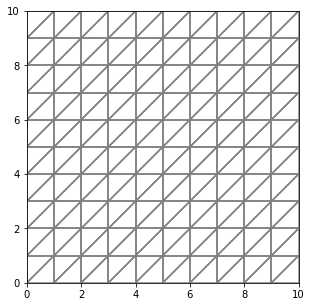

In [11]:
fig = plt.figure(figsize=(5, 5))
mapview = flopy.plot.PlotMapView(model=disv_ml)

linecollection = mapview.plot_grid()

### DISU (Unstructured Grid)

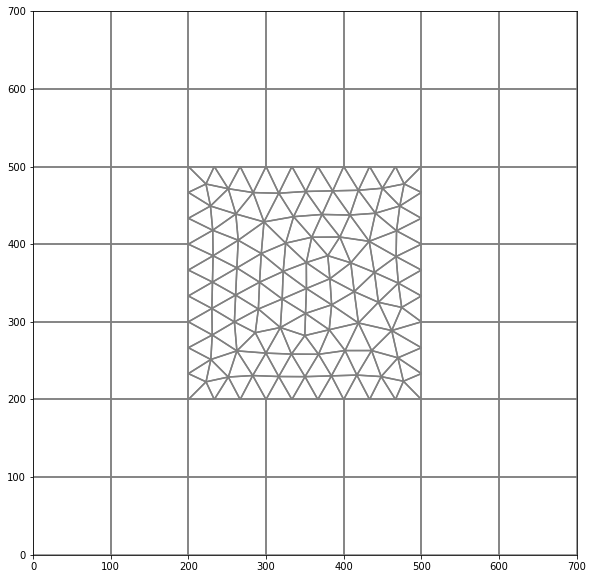

In [12]:
f = plt.figure(figsize=(10, 10))
mapview = flopy.plot.PlotMapView(modelgrid=disu_mg)

linecollection = mapview.plot_grid()

### Backward compatibility for DISU using `ModelMap`

/Users/jdhughes/Documents/Development/flopy_git/flopy_us/flopy/plot/map.py:1356: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


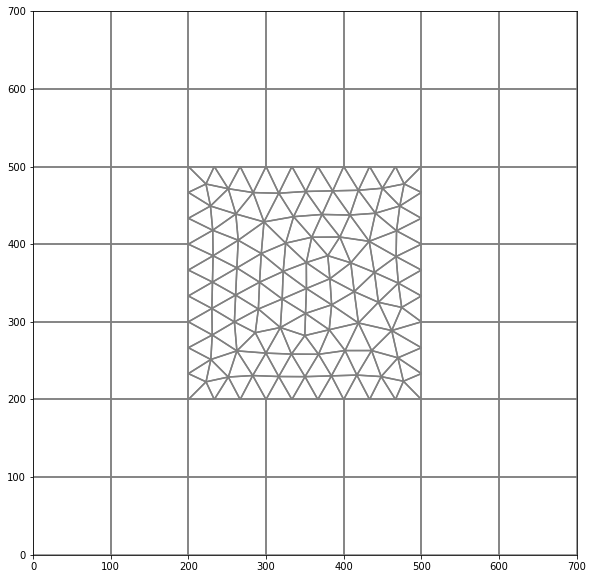

In [13]:
f = plt.figure(figsize=(10, 10))
modelmap = flopy.plot.ModelMap(sr=disu_sr)

linecollection = modelmap.plot_grid()

## Plotting Arrays with each of these examples

### DIS (Structured grid)

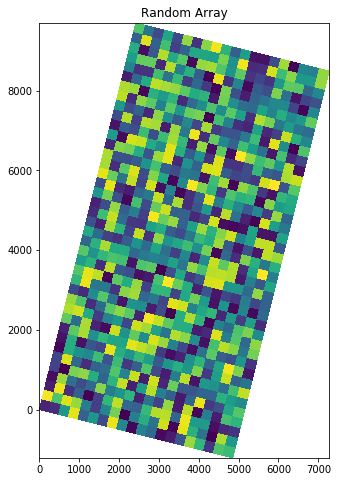

In [14]:
# Create a random array and plot it
a = np.random.random((dis_ml.dis.nrow, dis_ml.dis.ncol))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Random Array')
mapview = flopy.plot.PlotMapView(model=dis_ml)
quadmesh = mapview.plot_array(a)

### DIS Backward compatibility using `ModelMap`

/Users/jdhughes/Documents/Development/flopy_git/flopy_us/flopy/plot/map.py:1356: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


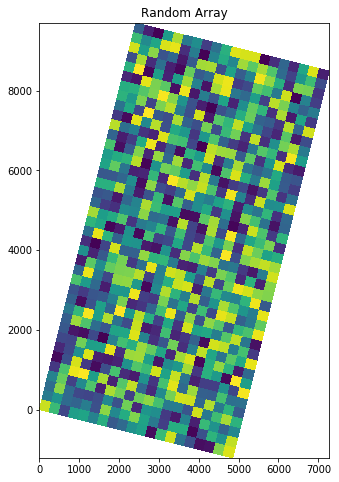

In [15]:
# Create a random array and plot it
a = np.random.random((dis_ml.dis.nrow, dis_ml.dis.ncol))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Random Array')
modelmap = flopy.plot.ModelMap(model=dis_ml, xll=0, yll=0, rotation=-14)
quadmesh = modelmap.plot_array(a)

### DISV (Vertex grid)

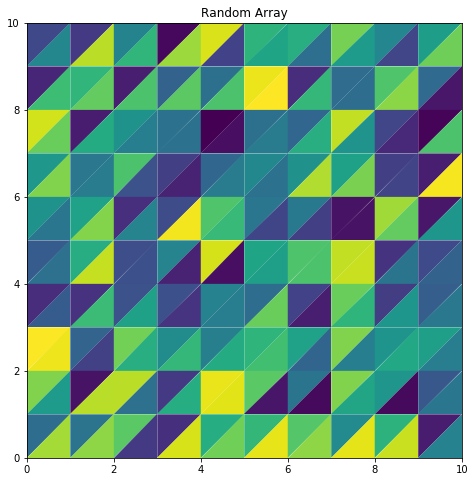

In [16]:
a = np.random.random(disv_ml.modelgrid.ncpl) * 20
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Random Array')
mapview = flopy.plot.PlotMapView(model=disv_ml)
quadmesh = mapview.plot_array(a)

### DISU (Unstructured grid)

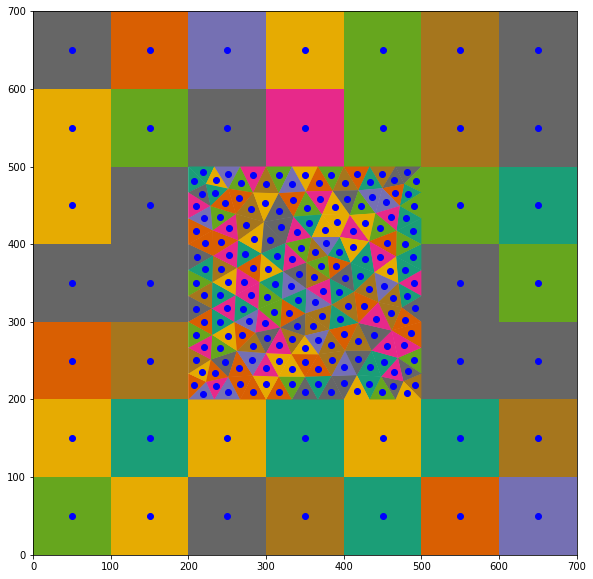

In [17]:
f = plt.figure(figsize=(10, 10))
a = np.random.random((ncpl[0]))
pmv = flopy.plot.PlotMapView(modelgrid=disu_mg)
pmv.plot_array(a)
plt.plot(xc, yc, 'bo');

### Backward compatibility for DISU using `ModelMap`

/Users/jdhughes/Documents/Development/flopy_git/flopy_us/flopy/plot/map.py:1356: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


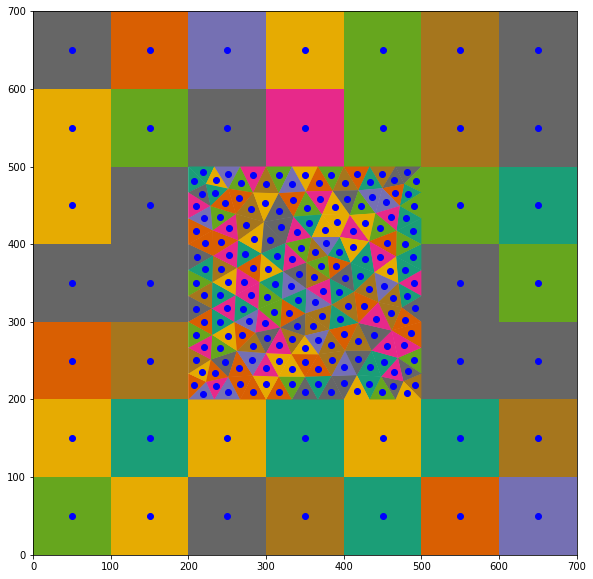

In [18]:
f = plt.figure(figsize=(10, 10))
mm = flopy.plot.ModelMap(sr=disu_sr)
mm.plot_array(a)
plt.plot(xc, yc, 'bo');

## Contouring arrays with each of these examples

### DIS (structured grid)

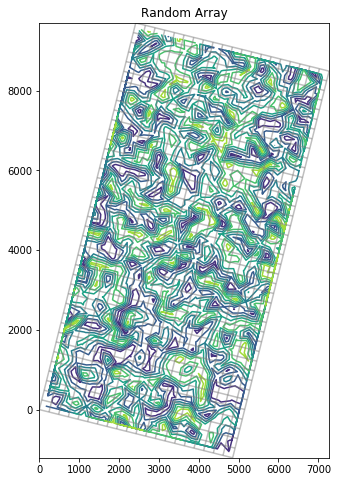

In [19]:
# Create a random array and contour it
a = np.random.random((dis_ml.dis.nrow, dis_ml.dis.ncol))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Random Array')

mapview = flopy.plot.PlotMapView(model=dis_ml)
quadmesh = mapview.contour_array(a)
linecollection = mapview.plot_grid(alpha=0.5)

### DIS backward compatibility using `ModelMap`

/Users/jdhughes/Documents/Development/flopy_git/flopy_us/flopy/plot/map.py:1356: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


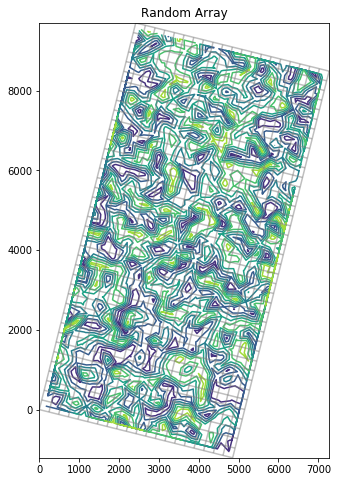

In [20]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Random Array')

modelmap = flopy.plot.ModelMap(model=dis_ml, xll=0, yll=0, rotation=-14)
quadmesh = modelmap.contour_array(a)
linecollection = modelmap.plot_grid(alpha=0.5)

### DISV (unstructured grid) example

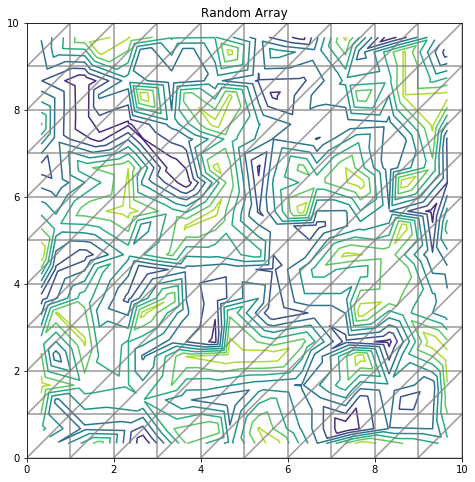

In [21]:
a = np.random.random(disv_ml.modelgrid.ncpl) * 20
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Random Array')

mapview = flopy.plot.PlotMapView(model=disv_ml)
quadmesh = mapview.contour_array(a)
linecollection = mapview.plot_grid(alpha=0.5)

### DISU (Unstructured grid) example

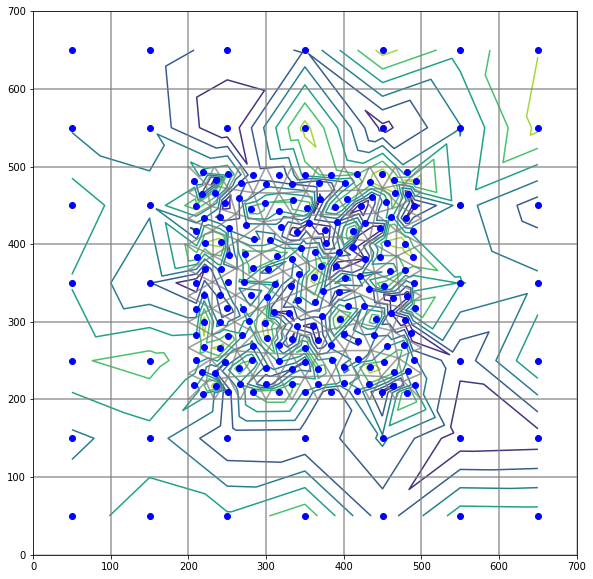

In [22]:
f = plt.figure(figsize=(10, 10))
a = np.random.random((ncpl[0]))
mv = flopy.plot.PlotMapView(modelgrid=disu_mg)
mv.contour_array(a)
mv.plot_grid(alpha=0.5)
plt.plot(xc, yc, 'bo');

### DISU Backward compatibility using `ModelMap`

/Users/jdhughes/Documents/Development/flopy_git/flopy_us/flopy/plot/map.py:1356: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


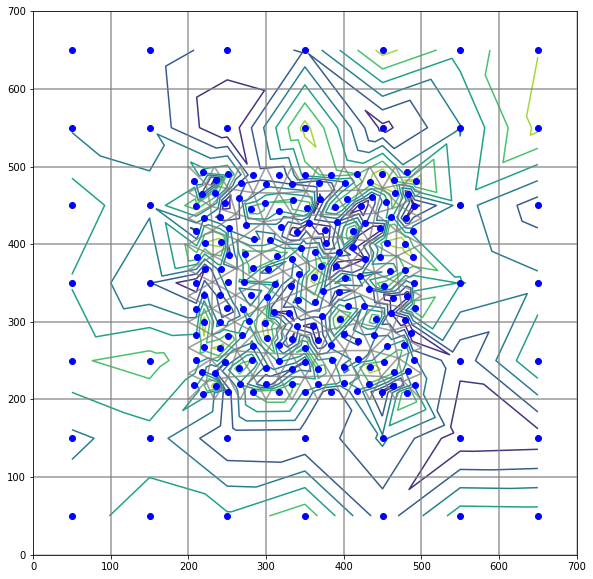

In [23]:
f = plt.figure(figsize=(10, 10))

mm = flopy.plot.ModelMap(sr=disu_sr)
mm.contour_array(a)
mm.plot_grid(alpha=0.5)
plt.plot(xc, yc, 'bo');

## Creating plots using data from MODPATH

In this portion of the notebook MODPATH particle tracking examples are loaded and then plotted using each of the grid types

### DIS (Structured grid example)

First the modpath model must be created and then run

In [24]:
mp = flopy.modpath.Modpath('freybergmp', exe_name="mp6", modflowmodel=dis_ml, model_ws=modelpth)
mpbas = flopy.modpath.ModpathBas(mp, hnoflo=dis_ml.bas6.hnoflo, hdry=dis_ml.lpf.hdry, 
                                 ibound=dis_ml.bas6.ibound.array, prsity=0.2, prsityCB=0.2)
sim = mp.create_mpsim(trackdir='forward', simtype='endpoint', packages='RCH')
mp.write_input()
mp.run_model()

mpp = flopy.modpath.Modpath('freybergmpp', exe_name="mp6", modflowmodel=dis_ml, model_ws=modelpth)
mpbas = flopy.modpath.ModpathBas(mpp, hnoflo=dis_ml.bas6.hnoflo, hdry=dis_ml.lpf.hdry, 
                                 ibound=dis_ml.bas6.ibound.array, prsity=0.2, prsityCB=0.2)
sim = mpp.create_mpsim(trackdir='backward', simtype='pathline', packages='WEL')
mpp.write_input()
mpp.run_model()

FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mp6
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+01                                                                       
Particle tracking complete. Writing endpoint file ...                                                                               
End of MODPATH simulation. Normal termination.
FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mp6
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+01                                                                       
Particle tracking complete. Writing endpoint file ...                                                         

(True, [])

Now to plot up the results of the particle tracking simulation

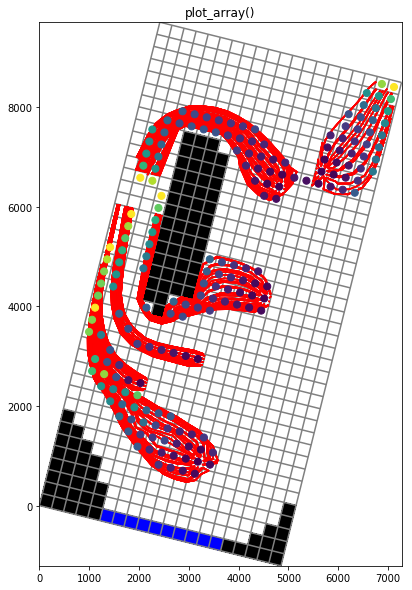

In [25]:
# load the endpoint data
endfile = os.path.join(modelpth, mp.sim.endpoint_file)
endobj = flopy.utils.EndpointFile(endfile)
ept = endobj.get_alldata()

# load the pathline data
pthfile = os.path.join(modelpth, mpp.sim.pathline_file)
pthobj = flopy.utils.PathlineFile(pthfile)
plines = pthobj.get_alldata()

# plot the data
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('plot_array()')
mapview = flopy.plot.PlotMapView(model=dis_ml)
quadmesh = mapview.plot_ibound()
linecollection = mapview.plot_grid()
for d in dis_ml.wel.stress_period_data[0]:
    mapview.plot_endpoint(ept, direction='starting', selection_direction='ending', selection=(d[0], d[1], d[2]), zorder=100)

# construct maximum travel time to plot (200 years - MODFLOW time unit is seconds)
travel_time_max = 200. * 365.25 * 24. * 60. * 60. 
ctt = '<={}'.format(travel_time_max)

# plot the pathlines
mapview.plot_pathline(plines, layer='all', colors='red', travel_time=ctt);

### Backward compatibility using `ModelMap`

/Users/jdhughes/Documents/Development/flopy_git/flopy_us/flopy/plot/map.py:1356: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


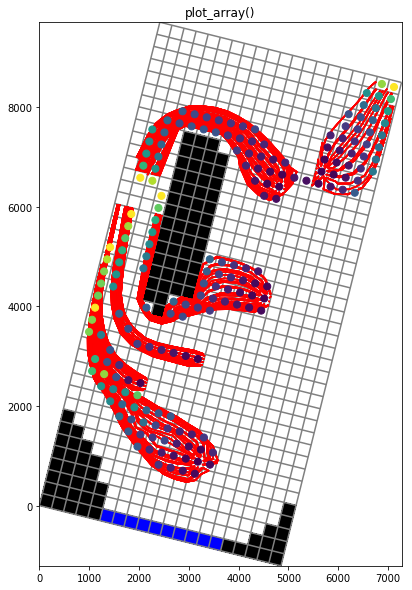

In [26]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('plot_array()')
modelmap = flopy.plot.ModelMap(model=dis_ml, xll=0, yll=0, rotation=-14)
quadmesh = modelmap.plot_ibound()
linecollection = modelmap.plot_grid()
for d in dis_ml.wel.stress_period_data[0]:
    modelmap.plot_endpoint(ept, direction='starting', selection_direction='ending', selection=(d[0], d[1], d[2]), zorder=100)

# construct maximum travel time to plot (200 years - MODFLOW time unit is seconds)
travel_time_max = 200. * 365.25 * 24. * 60. * 60. 
ctt = '<={}'.format(travel_time_max)

# plot the pathlines
modelmap.plot_pathline(plines, layer='all', colors='red', travel_time=ctt);

## DISV (vertex unstructured) example problem for MODPATH 7

### Get the modelgrid

In [27]:
model_name = 'mp7p2'
mp_namea = model_name + 'a_mp'
model_ws = os.path.join('data', 'mp7_ex2', 'mf6')
fname = os.path.join(model_ws, model_name + '.disv.grb')
grd = flopy.utils.MfGrdFile(fname, verbose=False)
iverts, verts = grd.get_verts()
modelgrid = grd.get_modelgrid()

### Load pathline and timeseries results

In [28]:
fpth = os.path.join(model_ws, mp_namea + '.mppth')
p = flopy.utils.PathlineFile(fpth)
p0 = p.get_alldata()

fpth = os.path.join(model_ws, mp_namea + '.timeseries')
ts = flopy.utils.TimeseriesFile(fpth)
ts0 = ts.get_alldata()

### Plot the pathline and timeseries data using `PlotMapView`

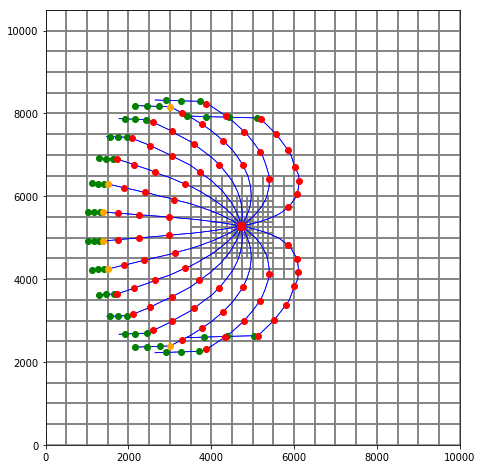

In [29]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mv = PlotMapView(modelgrid=modelgrid, ax=ax)
ax.set_xlim(0, 10000.)
ax.set_ylim(0, 10500.)
lc = mv.plot_grid()
mv.plot_pathline(p0, layer='all', color='blue', lw=0.75)
colors = ['green', 'orange', 'red']
for k in range(3):
    mv.plot_timeseries(ts0, layer=k, marker='o', lw=0, color=colors[k]);

### plot pathline and timeseries data using `ModelMap` (backward compatibility)

/Users/jdhughes/Documents/Development/flopy_git/flopy_us/flopy/utils/mfgrdfile.py:423: PendingDeprecationWarning: get_spatialreference will be depreciated get_modelgrid() is replacing it 
  warnings.warn(err_msg, PendingDeprecationWarning)
/Users/jdhughes/Documents/Development/flopy_git/flopy_us/flopy/plot/map.py:1356: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


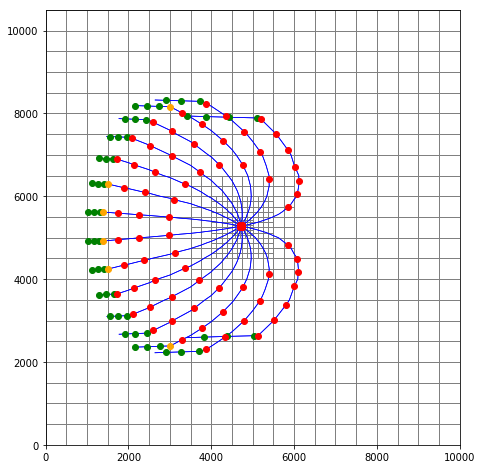

In [30]:
# Get the spatial reference object
sr = grd.get_spatialreference()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = ModelMap(sr=sr, ax=ax)
ax.set_xlim(0, 10000.)
ax.set_ylim(0, 10500.)
v = mm.plot_cvfd(verts, iverts, edgecolor='gray', facecolor="None")
mm.plot_pathline(p0, layer='all', color='blue', lw=0.75)
colors = ['green', 'orange', 'red']
for k in range(3):
    mm.plot_timeseries(ts0, layer=k, marker='o', lw=0, color=colors[k]);

## Plotting Discharge vectors

### DIS (structured grid) example using `PlotMapView`

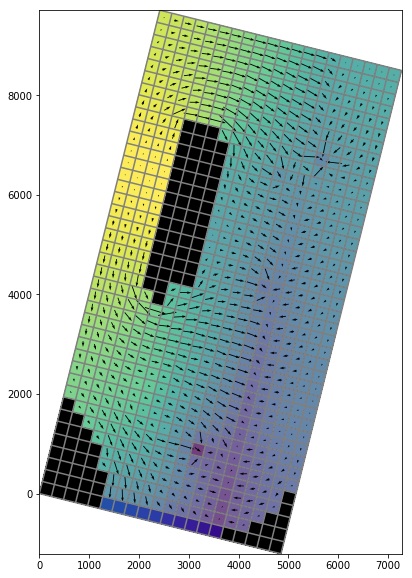

In [31]:
# get the head object
fname = os.path.join(modelpth, 'freyberg.hds')
hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()

# get the cbc object
fname = os.path.join(modelpth, 'freyberg.cbc')
cbb = flopy.utils.CellBudgetFile(fname)
frf = cbb.get_data(text='FLOW RIGHT FACE')[0]
fff = cbb.get_data(text='FLOW FRONT FACE')[0]

# plot the data!
fig = plt.figure(figsize=(10, 10))
mapview = flopy.plot.PlotMapView(model=dis_ml)
quadmesh = mapview.plot_ibound()
quadmesh = mapview.plot_array(head, masked_values=[999.], alpha=0.5)
quiver = mapview.plot_discharge(frf, fff, head=head)
linecollection = mapview.plot_grid()

### Backward compatibility using `ModelMap`

/Users/jdhughes/Documents/Development/flopy_git/flopy_us/flopy/plot/map.py:1356: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


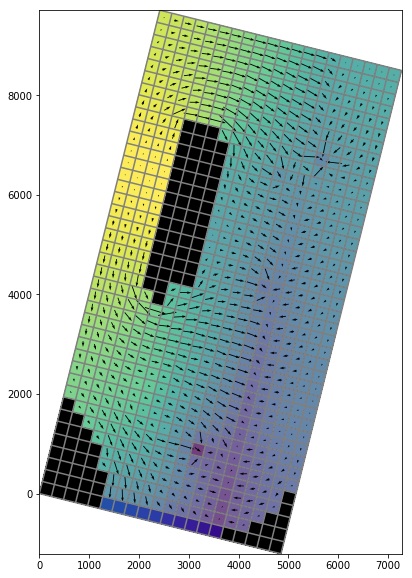

In [32]:
# plot the data!
fig = plt.figure(figsize=(10, 10))
modelmap = flopy.plot.ModelMap(model=dis_ml, xll=0, yll=0, rotation=-14)
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(head, masked_values=[999.], alpha=0.5)
quiver = modelmap.plot_discharge(frf, fff, head=head)
linecollection = modelmap.plot_grid()

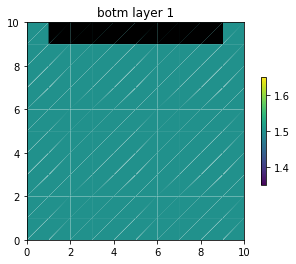

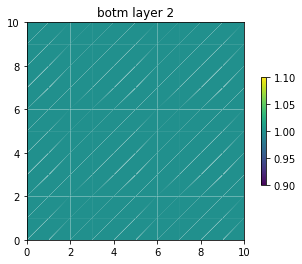

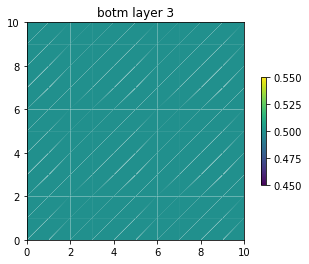

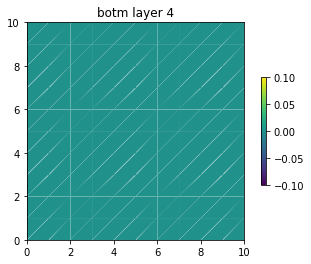

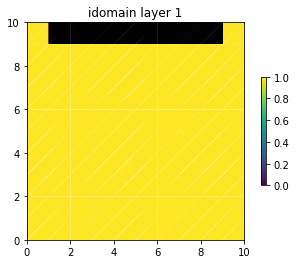

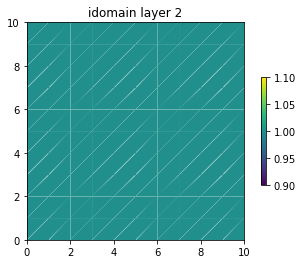

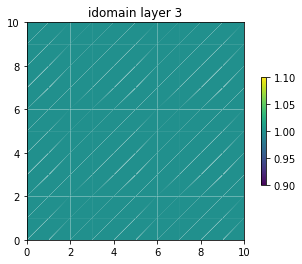

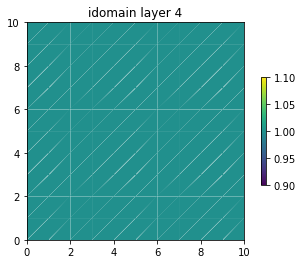

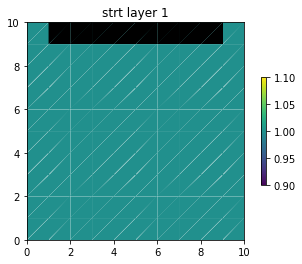

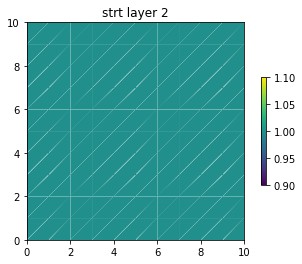

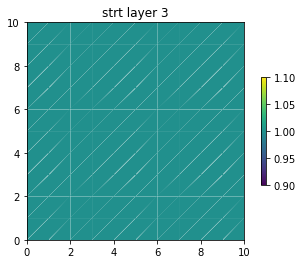

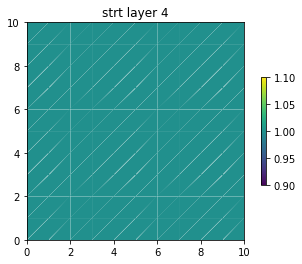

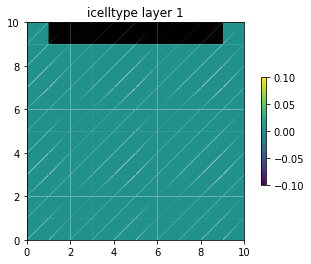

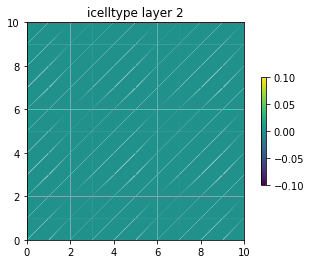

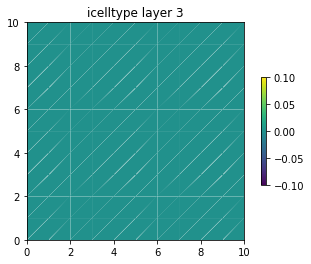

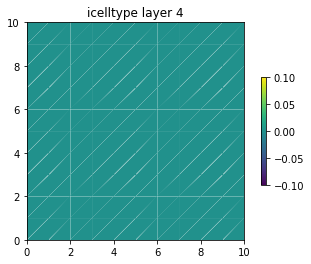

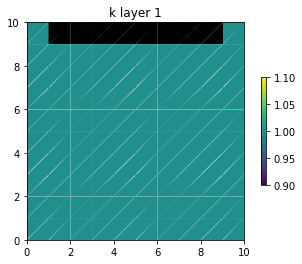

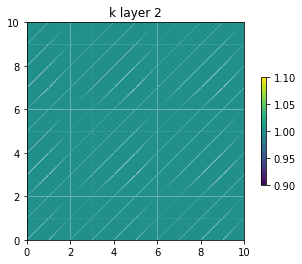

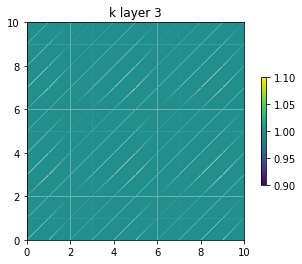

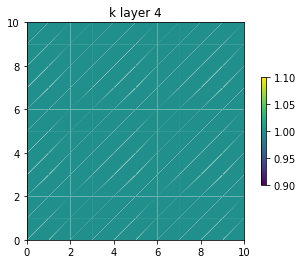

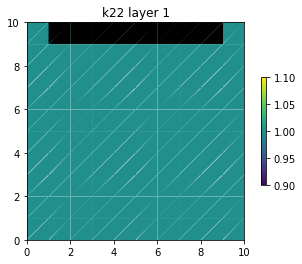

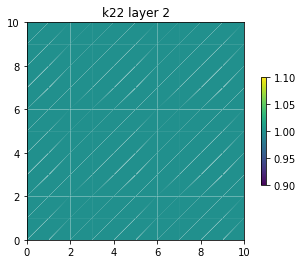

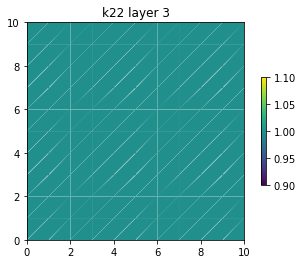

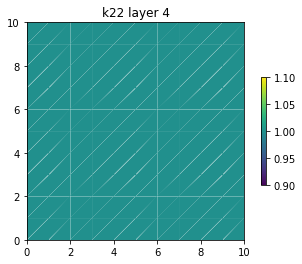

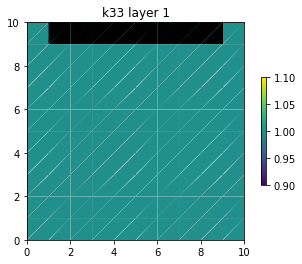

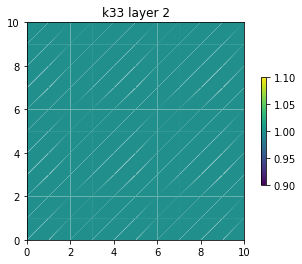

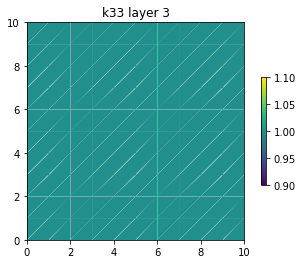

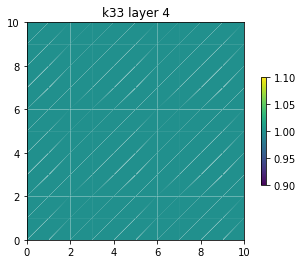

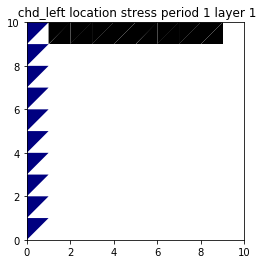

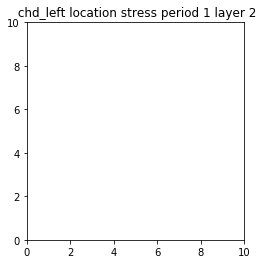

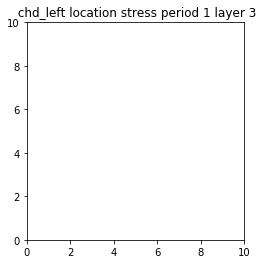

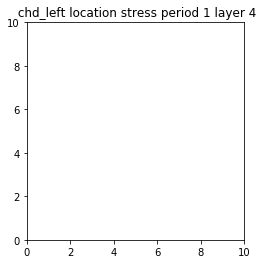

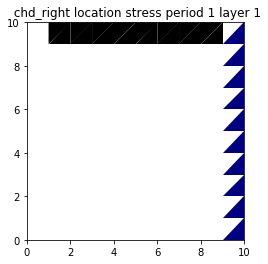

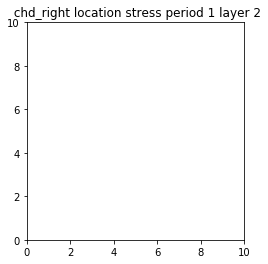

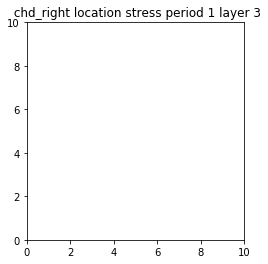

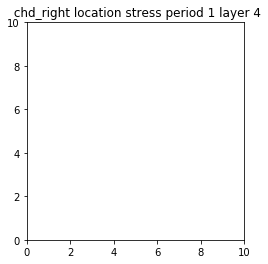

In [33]:
disv_ml.plot();